---
# **Group 15**
## - **Bishal Ghosh - (23200342)** (Secondary contributor to this code)
## - **Stebin Sebastian - (23200018)** (Primary contributor to this code)
## - **Thapanee Sasuwan - (23201498)** (Looked after the QA of the code)
## - **Ambarish Tirumalai - (23201747)** (Looked after the code comments and Markdown)
---

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


---
## Data Preprocessing
---

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import ssl
if getattr(ssl, '_create_unverified_context', None): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [11]:
import os
cwd = os.getcwd()
file_path = cwd + "/Diseases Data/colon_image_sets"

colon_aca_path = os.path.join(file_path, "colon_aca")
colon_n_path = os.path.join(file_path, "colon_n")

filelist_colon_aca = os.listdir(colon_aca_path)
filelist_colon_n = os.listdir(colon_n_path)

# Function to create dataframe
def create_dataframe(folder_path, label):
    filepaths = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    labels = [label for _ in range(len(filepaths))]
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Create dataframes
df_colon_aca = create_dataframe(colon_aca_path, 'colon_aca')
df_colon_n = create_dataframe(colon_n_path, 'colon_n')

# Concatenate the two dataframes
df = pd.concat([df_colon_aca, df_colon_n], ignore_index=True)





In [12]:
df

filepaths     labels
0     /Users/bishalghosh/Desktop/Trimester 2/Data Ma...  colon_aca
1     /Users/bishalghosh/Desktop/Trimester 2/Data Ma...  colon_aca
2     /Users/bishalghosh/Desktop/Trimester 2/Data Ma...  colon_aca
3     /Users/bishalghosh/Desktop/Trimester 2/Data Ma...  colon_aca
4     /Users/bishalghosh/Desktop/Trimester 2/Data Ma...  colon_aca
...                                                 ...        ...
3997  /Users/bishalghosh/Desktop/Trimester 2/Data Ma...    colon_n
3998  /Users/bishalghosh/Desktop/Trimester 2/Data Ma...    colon_n
3999  /Users/bishalghosh/Desktop/Trimester 2/Data Ma...    colon_n
4000  /Users/bishalghosh/Desktop/Trimester 2/Data Ma...    colon_n
4001  /Users/bishalghosh/Desktop/Trimester 2/Data Ma...    colon_n

[4002 rows x 2 columns]

---
## Splitting Data and Image generator
---

In [13]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [14]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 3199 validated image filenames belonging to 2 classes.
Found 480 validated image filenames belonging to 2 classes.
Found 321 validated image filenames belonging to 2 classes.


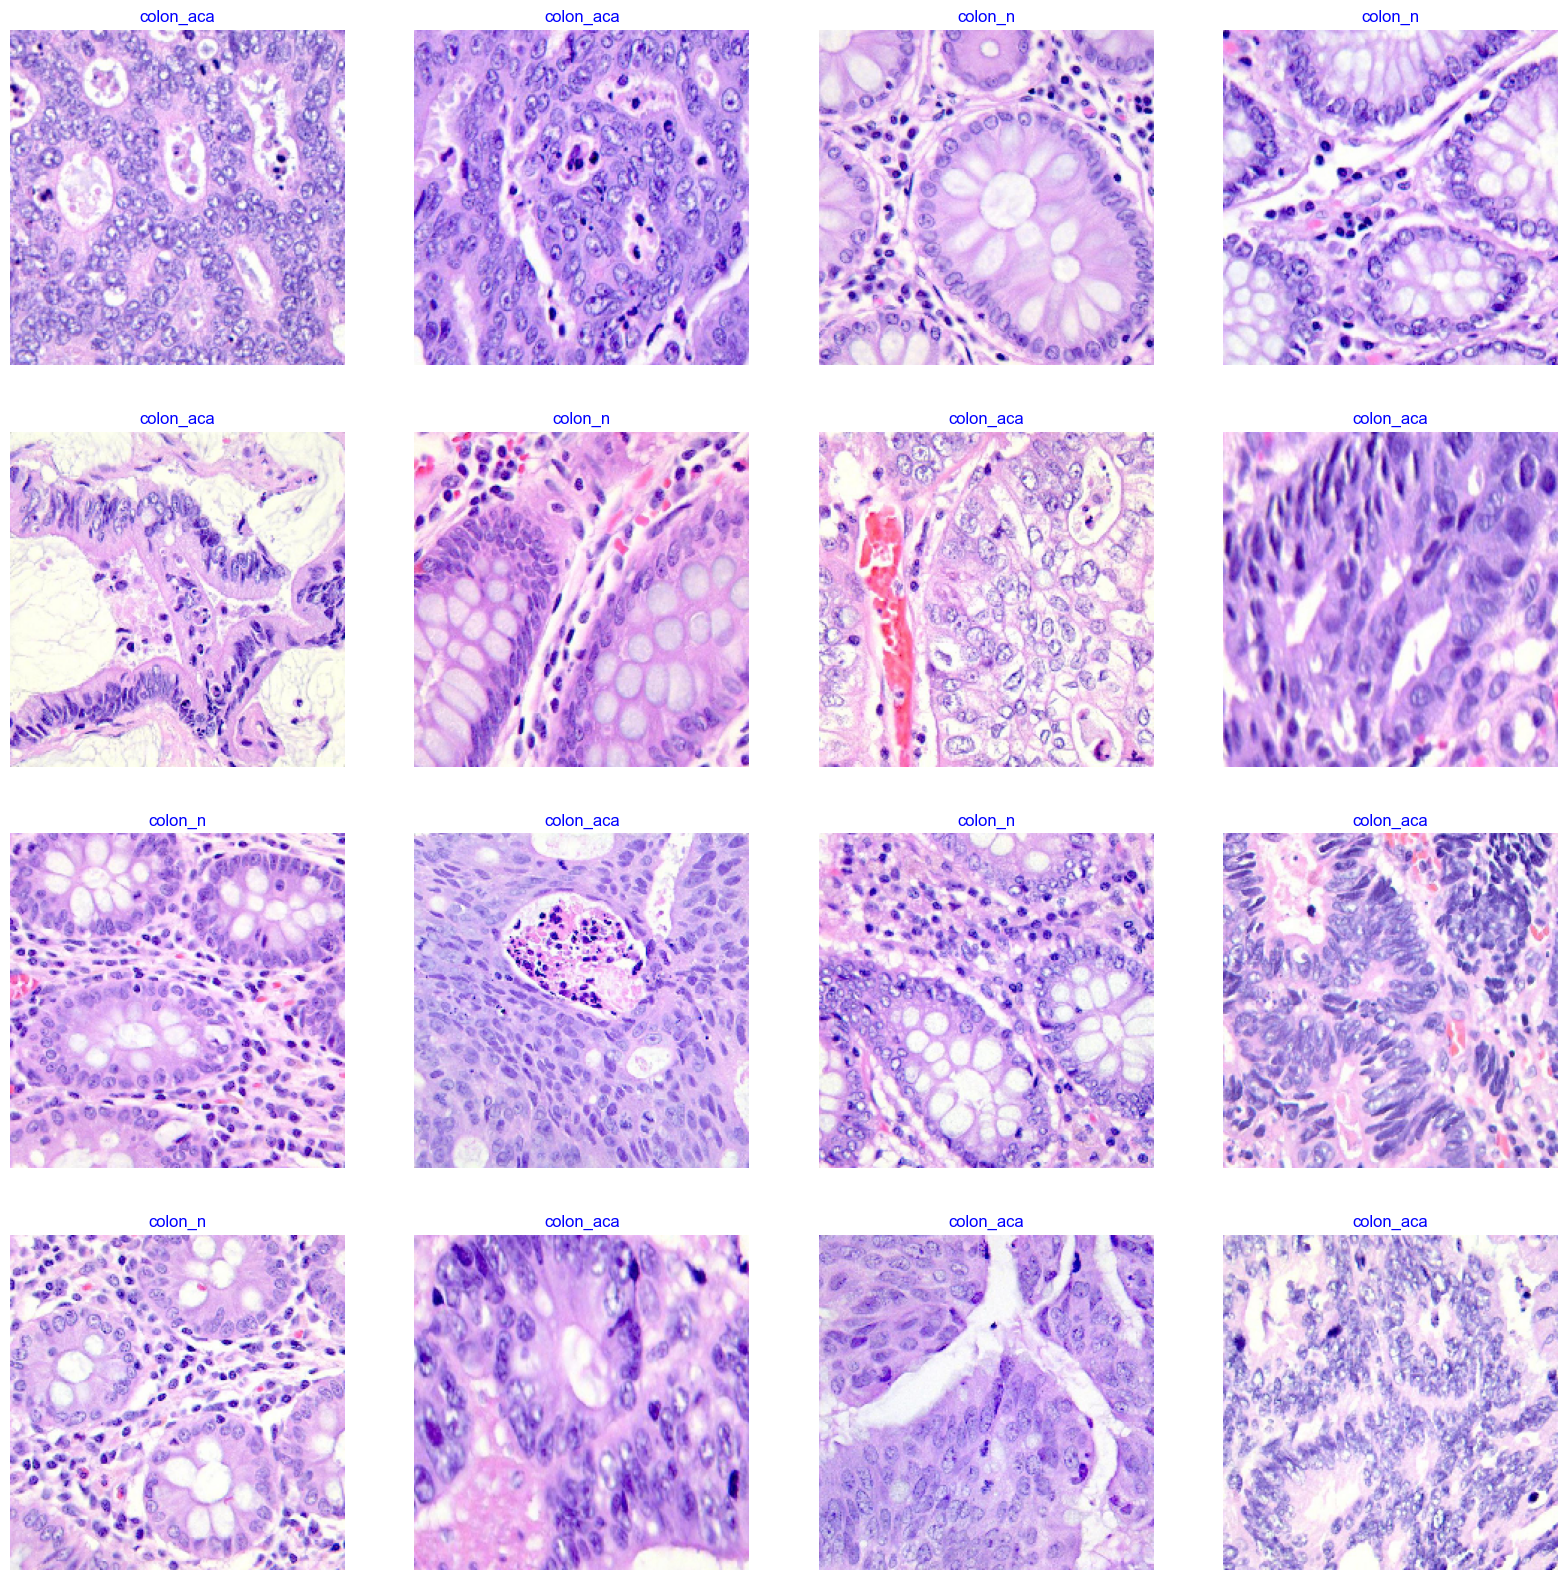

In [15]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

---
## Optimizing with ADAMAX & Training Model
---

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax


class_count = len(train_gen.class_indices)  # Number of unique classes

# Define image size and channels
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create the base model from the pre-trained model EfficientNetB3
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False, 
    weights="imagenet", 
    input_shape=img_shape, 
    pooling='max'
)

# Build a model
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(0.45),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.build((None,) + img_shape) 

model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

---
### 10 Epoch used - takes approx. 2hrs 30mins to run on an M2 Macbook Air or i5 8th Gen Windows with 16GB RAM
---

In [17]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1053s 5s/step - accuracy: 0.8447 - loss: 11.4601 - val_accuracy: 0.7042 - val_loss: 5.6462
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 945s 5s/step - accuracy: 0.8523 - loss: 5.2399 - val_accuracy: 0.9771 - val_loss: 4.1677
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 818s 4s/step - accuracy: 0.9094 - loss: 3.8120 - val_accuracy: 0.9792 - val_loss: 2.8690
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1011s 5s/step - accuracy: 0.9428 - loss: 2.6739 - val_accuracy: 1.0000 - val_loss: 2.0305
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 859s 4s/step - accuracy: 0.9405 - loss: 1.8998 - val_accuracy: 1.0000 - val_loss: 1.4178
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 797s 4s/step - accuracy: 0.9457 - loss: 1.3809 - val_accuracy: 0.9979 - val_loss: 1.0295
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 846s 4s/step - accuracy: 0.9489 - loss: 1.0289 - val_accuracy: 1.0000 - val_loss: 0.7787
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 850s 4s/step - accuracy: 0.9505 - loss: 0.7988 - val_a

---
### Display Model performance
---

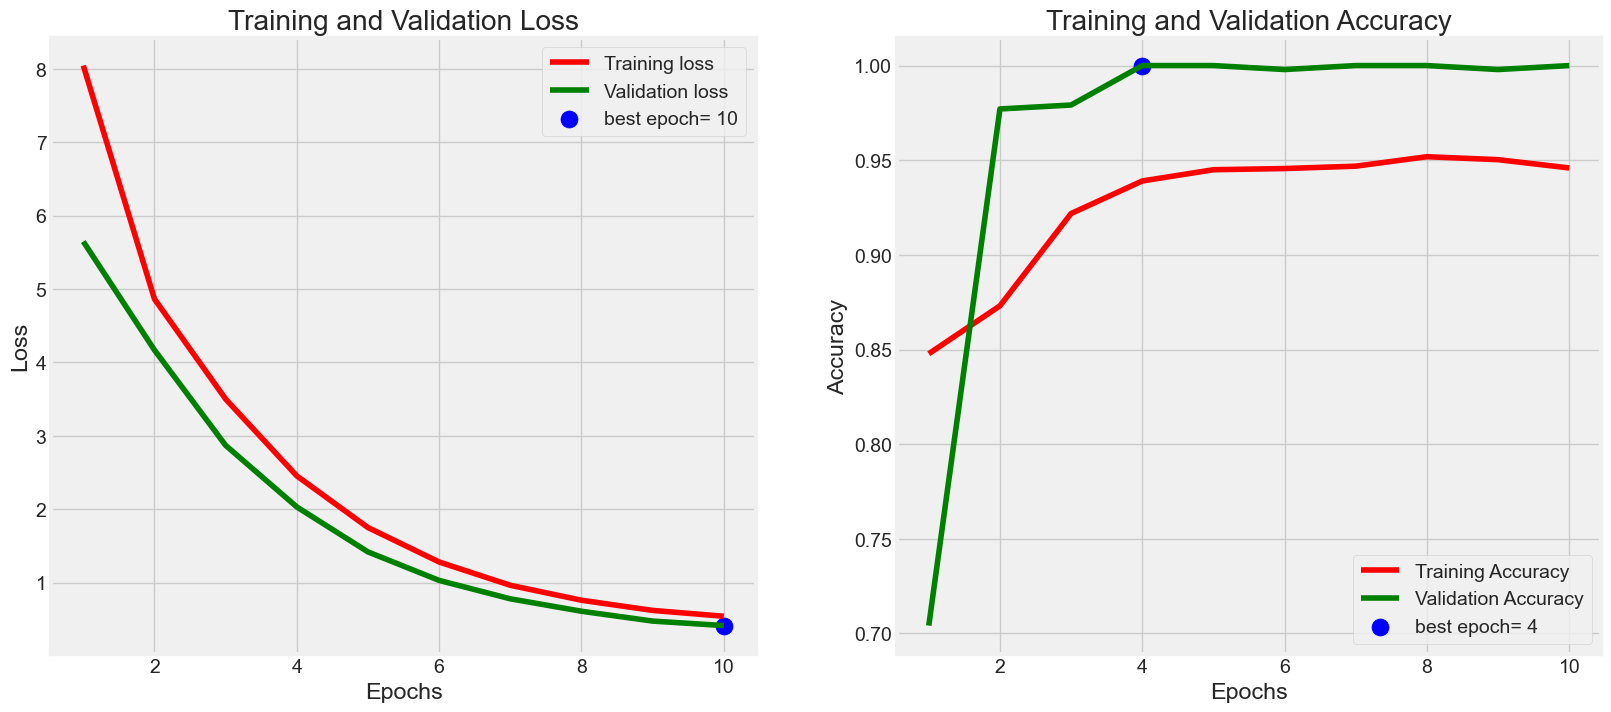

In [18]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [19]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

107/107 ━━━━━━━━━━━━━━━━━━━━ 88s 824ms/step - accuracy: 0.9987 - loss: 0.4174
107/107 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 1.0000 - loss: 0.4137 
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 0.4100 
Train Loss:  0.4161120653152466
Train Accuracy:  0.9994158744812012
--------------------
Validation Loss:  0.41402146220207214
Validation Accuracy:  1.0
--------------------
Test Loss:  0.41056302189826965
Test Accuracy:  1.0


---
### Get Predictions
---

In [20]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 855ms/step


---
### Confusion Matrics and Classification Report
---

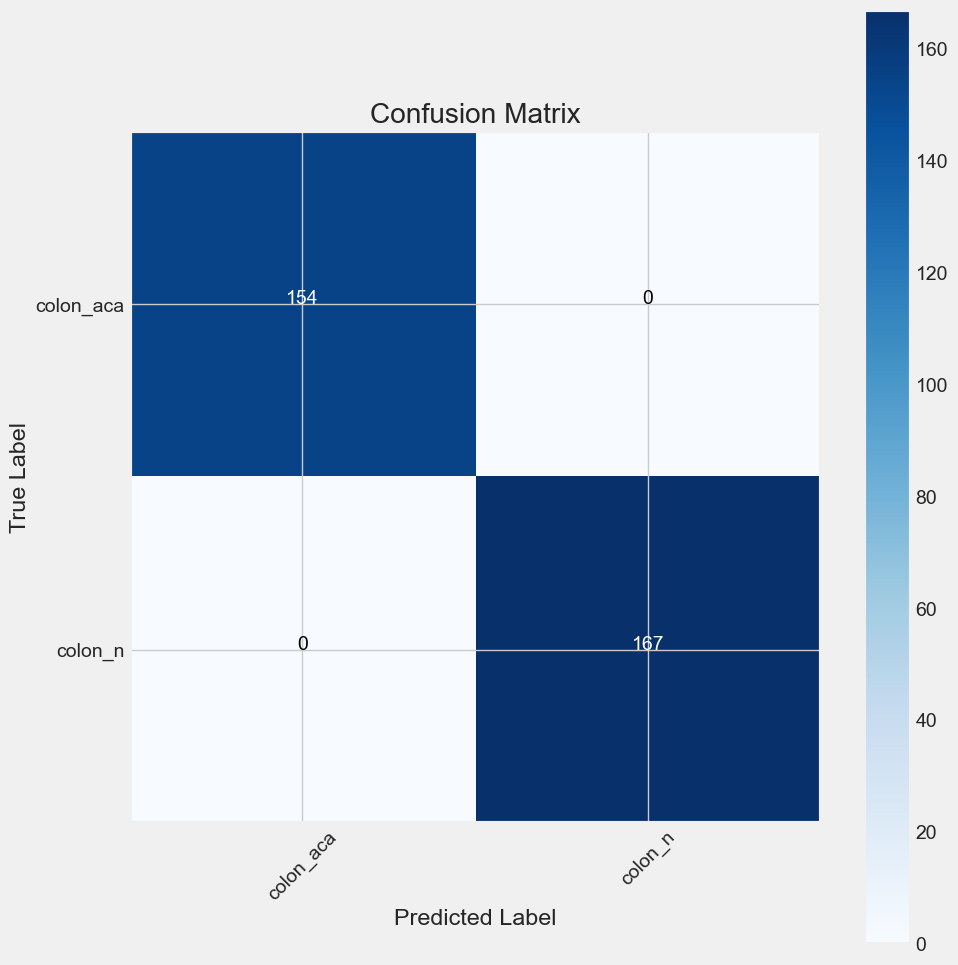

In [25]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [27]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       154
     colon_n       1.00      1.00      1.00       167

    accuracy                           1.00       321
   macro avg       1.00      1.00      1.00       321
weighted avg       1.00      1.00      1.00       321



In [28]:
#Save the model
model.save('Colon Cancer.h5')

In [29]:
loaded_model = tf.keras.models.load_model('Colon Cancer.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [63]:
import random

random_number = random.randint(1, 2000)
print("Random number between 1 and 2000:", random_number)

current = os.getcwd()
print(current)

Random number between 1 and 2000: 641
/Users/bishalghosh/Desktop/Trimester 2/Data Management & Mining/Project - Group/Project_MIS41270


---
## Testing model's ability to predict with a random image
---

In [65]:
image_path = current+'/Diseases Data/colon_image_sets/colon_aca/colonca'+str(random_number)+'.jpeg'
image = Image.open(image_path)
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Colon_ACA - Positive Colon Cancer', 'Colon_N - Negative Colon Cancer']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Colon_ACA - Positive Colon Cancer


In [67]:
image_path = current+'/Diseases Data/colon_image_sets/colon_n/colonn'+str(random_number)+'.jpeg'
image = Image.open(image_path)
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Colon_ACA - Positive Colon Cancer', 'Colon_N - Negative Colon Cancer']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Colon_N - Negative Colon Cancer
